### Inferenced

In [ ]:
!python inference.py -m samples/5eddafa82ab72_m1_news__inform_3111_15.flac -c configs/dualpathrnn.yml -w weights/dualpathrnn/DualPath_RNN_epoch_800_-10.1744.pt -s samples

saved in: samples/DualPath_RNN/spk1/5eddafa82ab72.flac
saved in: samples/DualPath_RNN/spk2/m1_news__inform_3111_15.flac


### Ploting loss

**Dualpathrnn**

In [1]:
from utils.plot import save_graph_tb_log_metrics

График сохранён в pics/Loss_Train_Val.png


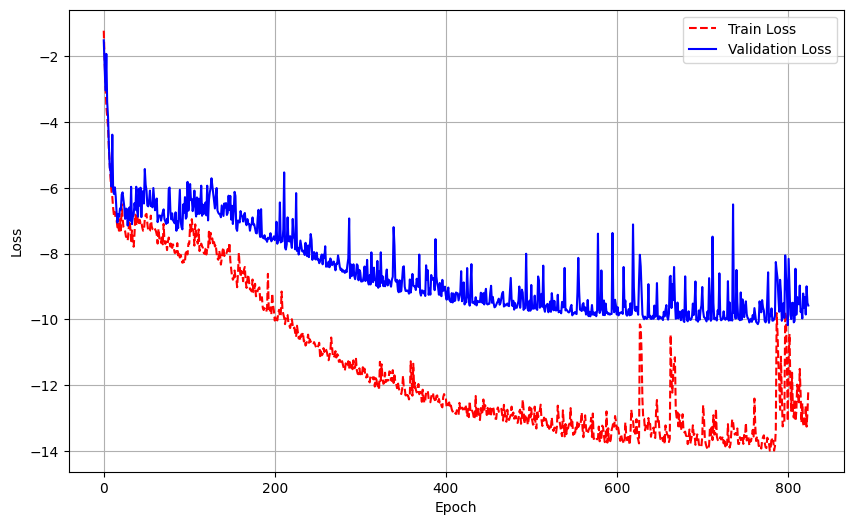

In [8]:
save_graph_tb_log_metrics(
    train_csv_path='checkpoints/dualpathrnn/TRAIN_LOSS_CONCATED.csv',
    val_csv_pathn='checkpoints/dualpathrnn/VALID_LOSS_CONCATED.csv',
    name_ox='Epoch',
    name_oy='Loss',
    loc = 'upper right',
    pth_save='pics/Loss_Train_Val.png'
)

График сохранён в pics/SISNR_Train_Val.png


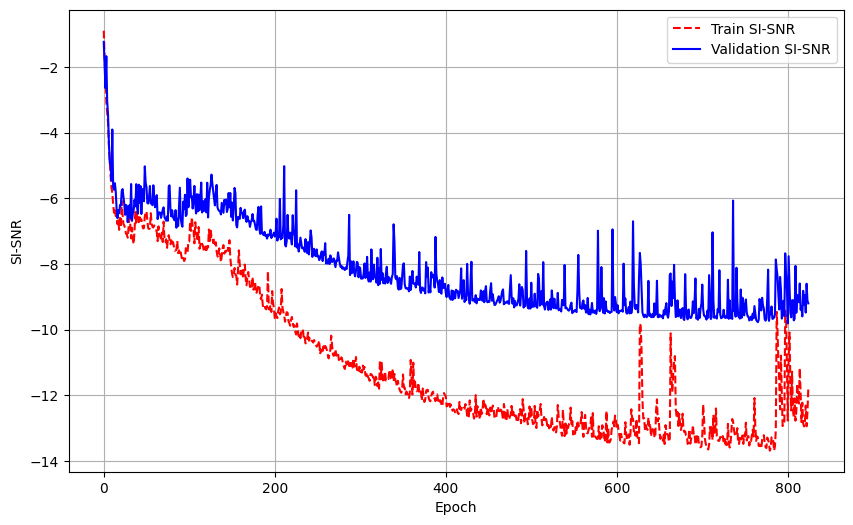

In [2]:
save_graph_tb_log_metrics(
    train_csv_path='checkpoints/dualpathrnn/TRAIN_SISNR_CONCATED.csv',
    val_csv_pathn='checkpoints/dualpathrnn/VALID_SISNR_CONCATED.csv',
    name_ox='Epoch',
    name_oy='SI-SNR',
    loc = 'upper right',
    pth_save='pics/SISNR_Train_Val.png'
)

График сохранён в pics/SDR_Train_Val.png


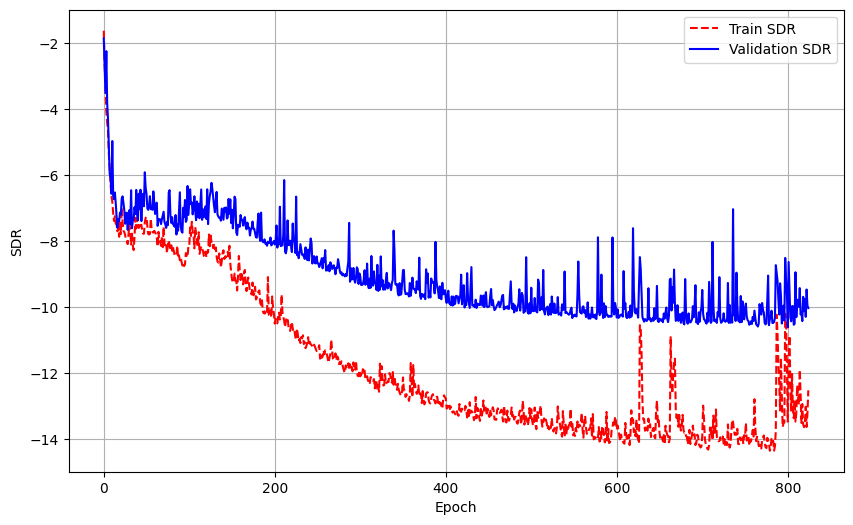

In [3]:
save_graph_tb_log_metrics(
    train_csv_path='checkpoints/dualpathrnn/TRAIN_SDR_CONCATED.csv',
    val_csv_pathn='checkpoints/dualpathrnn/VALID_SDR_CONCATED.csv',
    name_ox='Epoch',
    name_oy='SDR',
    loc = 'upper right',
    pth_save='pics/SDR_Train_Val.png'
)

**ConvTasnet**

In [ ]:
# ToDO



**Sepformer**

### Evaluation

In [1]:
import argparse
import sys

import torch
from torchmetrics.audio import PermutationInvariantTraining as PIT
from torchmetrics.functional.audio import signal_distortion_ratio as sdr
from torchmetrics.functional.audio import scale_invariant_signal_noise_ratio as sisnr
from tqdm.notebook import tqdm

from utils.load_config import load_config  
from models import MODELS
from data import DiarizationDataset

In [2]:
def evaluate(pth_to_cfg, test_dataloader, pth_to_weight) -> None:
    cfg = load_config(pth_to_cfg)
    model_class = MODELS[cfg['trainer']['model_name']]
    model = model_class(**cfg['model'])
    device = cfg['trainer']['device']
    model.to(device)

    dicts = torch.load(pth_to_weight, map_location=device, weights_only=False)
    model.load_state_dict(dicts['model_state_dict'])
    
    model.eval()
    pit_sdr = PIT(sdr).to(device)
    pit_sisnr = PIT(sisnr).to(device)

    for inputs, labels in tqdm(test_dataloader):
        '''
        batch = 1 spk = 2 time = 16000
        inputs: [batch, time] 
        outputs and labels: [torch.randn(batch, time) for _ in range(spk)]  
        expectention outputs and labels for torch audio-loss: torch.Size([batch, spk, time])
        '''
        inputs, labels = inputs.to(device), [l.to(device) for l in labels]
        with torch.no_grad():
            outputs = [s.detach() for s in model(inputs)]
            labels = torch.stack(labels, dim=1).to(device)
            outputs = torch.stack(outputs, dim=1).to(device)
            pit_sdr.update(outputs, labels)
            pit_sisnr.update(outputs, labels)
        
    print('sdr', pit_sdr.compute().item())
    print('sisnr', pit_sisnr.compute().item())

In [3]:
# Test data loader
testdataset_config_path = "./configs/test_dataset.yml"
testdataset_cfg = load_config(testdataset_config_path)
datamodule = DiarizationDataset(**testdataset_cfg['data']).setup(stage = 'eval')
test_dataloader = datamodule.test_dataloader()

Size of test set: 9404
Elapsed time 'setup': 00:00:07.98


**Dualpath-RNN**

In [4]:
evaluate(pth_to_cfg = "./configs/dualpathrnn.yml", 
         test_dataloader = test_dataloader, 
         pth_to_weight = './weights/dualpathrnn/DualPath_RNN_epoch_654_-10.0199.pt'
        )

  0%|          | 0/9404 [00:00<?, ?it/s]

sdr 10.523404121398926
sisnr 9.722249984741211


**Conv-TasNet**

In [ ]:
evaluate(pth_to_cfg = "./configs/convtasnet.yml", 
         test_dataloader = test_dataloader, 
         pth_to_weight = './weights/.pt'
        )

**Sepformer**

In [ ]:
evaluate(pth_to_cfg = "./configs/sepformer.yml", 
         test_dataloader = test_dataloader, 
         pth_to_weight = './weights/.pt'
        )